<img src="logo.png" align="left">

## Stackarator Tutorial

Welcome the the Stackarator tutorial! Stackarator is a tool for stacking (sub-)millimetre datacubes of extended sources to extract weak lines. For instance, perhaps you have $^{12}$CO ALMA observations of a nice extended galaxy/protoplanetary disc/molecular cloud and $^{13}$CO was in the lower sideband. You may not detect the weaker line purely in the datacubes, but by using the $^{12}$CO velocity information you can stack the data and pull the signal out. 

Below I will show you how to use this tool to do just that!

### Stackarator install

To start we need to install Stackarator. This can be done using PiPy, with the command `pip install stackarator`. You can add `--user` if you need to install on a system where you don't have admin rights. 

Stackarator requires the following modules, which pip should install automatically for you if you dont have them already:

* numpy
* matplotlib
* scipy
* tqdm

If you install Stackarator from the github source files then you will want to ensure you have these packages installed yourself.

### Example usage

Here we will show a basic example of Stackarator usage, using a noiseless mock observation created using the `KinMS` python package (see https://github.com/TimothyADavis/KinMSpy).  This allows us to modify the noise level etc on the fly. I am also using the plotting tool that comes with that package to visulise the data for you here, but thats not required in any way by Stackarator. 

In [113]:
#imports
from stackarator import stackarator
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from kinms.utils.KinMS_figures import KinMS_plotter # just for making nice plots

Now we can initalise the stackarator object, and read in our fits datacube. This datacube has RA-DEC-velocity axes. RA-DEC-Frequency cubes are also supported, but it should be noted that internally the code will convert to velocities using the _radio_ redshift definition. 

In [114]:
stack=stackarator()
stack.read_fits_cube("TestGalaxy_simcube.fits",rms=0)

If you don't supply the RMS then the code will try and estimate it from channels 2->5 in your cube - if that won't work for you then remember to supply it directly.

Lets look and see what our galaxy looks like. You can access various properties of your loaded datacube to help with this. 

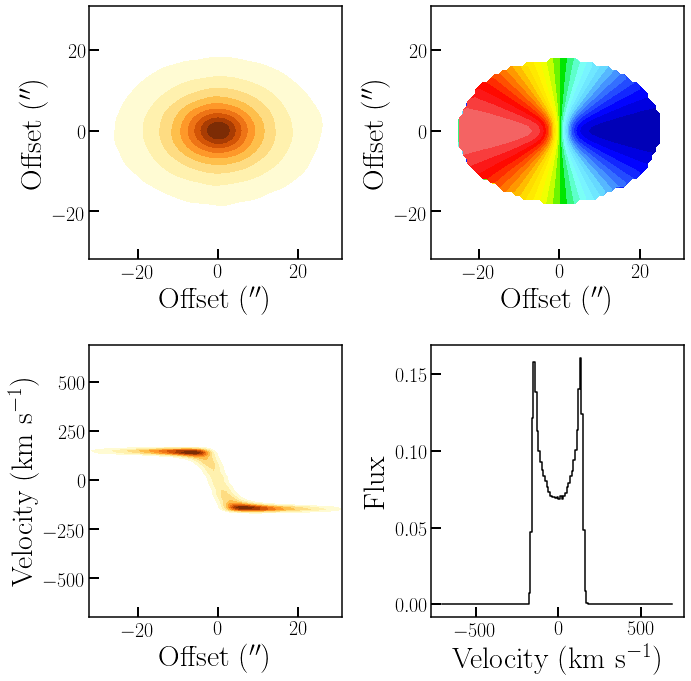

In [115]:
KinMS_plotter(stack.datacube, stack.xcoord.size, stack.ycoord.size, stack.vcoord.size*stack.dv,\
              1, stack.dv, [stack.bmaj,stack.bmin,stack.bpa],posang=90).makeplots()

Now we can read in the velocity field we want to use to stack the data. This doesnt have to be evaluated on the same pixel grid, or even observed at the same resolution, as 2D interpolation is used to match it to the datacube. In this case its just the moment one of the data shown above. 

In [116]:
stack.read_fits_mom1('TestGalaxy_moment1.fits')

Note that if your moment one has been centred around zero, then the code will check and see if the original systemic velocity is encoded in the SYSVEL fits header keyword. If not then you will need to pass the vsys (in km/s) to this command. E.g. `stack.read_fits_mom1('TestGalaxy_moment1.fits',vsys=1194)`

Now we can stack this data! Obviously its noiseless right now, so its a very easy case!

100%|██████████| 4096/4096 [00:00<00:00, 9875.40it/s]


(-200, 200)

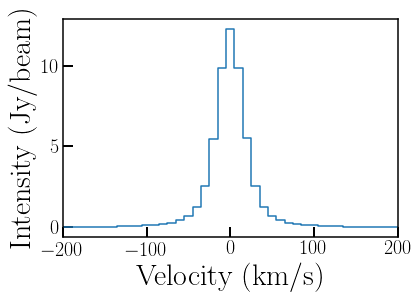

In [117]:
vout,outspec,outrms,outn = stack.stack()

plt.plot(vout,outspec,drawstyle='steps-mid')
plt.xlabel("Velocity (km/s)")
plt.ylabel("Intensity (Jy/beam)")
plt.xlim(-200,200)

As you can see, we get a nice single peak, with an _approximately_ gaussian shape. 

NOTE: For galaxies at least, the stacked line is unlikely to be exactly gaussian. As seen in the example above, objects where the rotation curve rises quickly at the centre will show broad wings around the central gaussian peak. This is _not_ a signature of non-circular motions (our model galaxy only has a perfectly rotating gas disc), but simply reflects the presence of beam smearing. If you want to fit a function to estimate total fluxes then a nested double gaussian usually provides a good fit. 

Now, as we have a perfect noiseless example, we can check for consistency! Do we retrieve all the flux in the stacked spectrum?

In [118]:
print("Total flux in this stacked line is",outspec.sum()*stack.dv,"Jy/beam km/s")
print("Total flux in the original cube is",stack.datacube.sum()*stack.dv,"Jy/beam km/s")

Total flux in this stacked line is 543.7955906725539 Jy/beam km/s
Total flux in the original cube is 543.7955906725537 Jy/beam km/s


Yes we do! Now we can try something more realistic. Lets add significant noise, and try again.

In [128]:
from numpy.random import default_rng
rng = default_rng()
rms=3e-2
noise=(rng.standard_normal((stack.xcoord.size,stack.ycoord.size,stack.vcoord.size))*rms)


import copy
stack2=copy.deepcopy(stack)
stack2.datacube=stack.datacube+noise
stack2.rms=rms


Lets plot the integrated spectra from both cubes, and see how much of a mess we made:

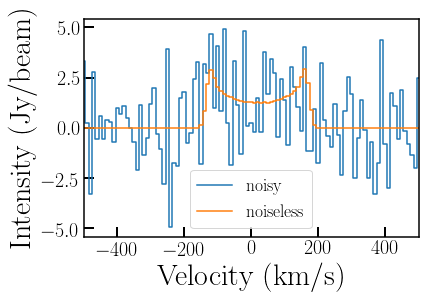

In [129]:
plt.plot(stack2.vcoord,stack2.datacube.sum(axis=0).sum(axis=0),drawstyle='steps-mid',label="noisy")
plt.plot(stack.vcoord,stack.datacube.sum(axis=0).sum(axis=0),drawstyle='steps-mid',label="noiseless")
plt.xlim(-500,500)
plt.xlabel("Velocity (km/s)")
plt.ylabel("Intensity (Jy/beam)")
plt.legend()

Lets see what stackarator makes of this!

100%|██████████| 4096/4096 [00:00<00:00, 10418.07it/s]


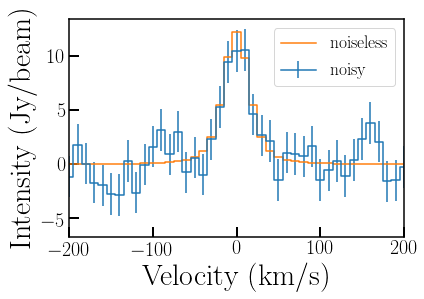

In [130]:
vout2,outspec2,outrms2,outn2 = stack2.stack()

plt.errorbar(vout2,outspec2,yerr=outrms2,drawstyle='steps-mid',label="noisy")
plt.plot(vout,outspec,drawstyle='steps-mid',label="noiseless")
plt.xlim(-200,200)
plt.xlabel("Velocity (km/s)")
plt.ylabel("Intensity (Jy/beam)")
plt.legend()

As you can see we are able to retrive the signal buried in the noisy data. Stackarator provides us with uncertanty estimates for each channel, and indicates the number of spaxels summed (the `outn` variable above). 

## More advanced usage

Stackarator has other (hopefully) useful features built in! We will cover two of these here. 

### Elliptical apertures

Stackarator can define elliptical regions to conduct our stacking within. In the code below we will take advantage of this to stack the spectra in two different apertures. 

100%|██████████| 662/662 [00:00<00:00, 8633.05it/s]


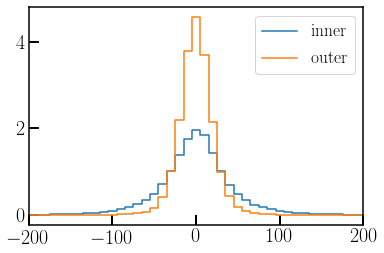

In [133]:
gal_centre=[12.,10.] # RA and Dec of our mock galaxy centre
inc=45 #inclination of our mock galaxy
pa=90 #position angle of our mock galaxy

## stack the inner 10 arcseconds
stack.define_region_ellipse(gal_centre,inc,pa,rad_inner=0,rad_outer=10)
vout_inner,outspec_inner,outrms_inner,outn_inner = stack.stack()

## Now stack the 10-20 arcsecond region
stack.define_region_ellipse(gal_centre,inc,pa,rad_inner=10,rad_outer=20)
vout_outer,outspec_outer,outrms_outer,outn_outer = stack.stack()

plt.plot(vout_inner,outspec_inner,drawstyle='steps-mid',label="inner")
plt.plot(vout_outer,outspec_outer,drawstyle='steps-mid',label="outer")
plt.xlim(-200,200)
plt.legend()


You can really see the difference in the shape of the stacked line caused by beam smearing. This elliptical apperture stacking can be useful both for creating radial profiles of faint lines, and to define masks to just sum part of your datacube. 

### Reading in arrays rather than fits files

If you are working with models, for instance, you might not want to read your data in from FITS files. Stackarator provides two convience functions to enable this:

Calls to `stack.read_fits_cube(filename,rms=rms)` can be replaced with calls to `stack.input_cube(cube,xcoord,ycoord,vcoord,rms=rms)`, where cube is a 3D-array (X,Y,Vel), and xcoord, ycoord and vcoord are 1D arrays defining the X,Y and Velocity axes. 

In a similar way, calls to `stack.read_fits_mom1(filename,vsys=vsys)` can be replaced with `stack.input_mom1(x1,y1,mom1,vsys=vsys)` where mom1 is a 2D array of intensity-weighted mean velocities, and x1 and y1 are 1D arrays defining the image axes. 